# Test ResNet-Based Fusion Model

This notebook tests the ResNet-based fusion model using CT and MRI images from the Harvard-Medical-Image-Fusion-Datasets.

## Overview
- Load trained ResNet fusion model from checkpoint
- Test on sample CT-MRI image pairs
- Evaluate fusion quality with comprehensive metrics
- Visualize results with side-by-side comparisons

In [9]:
# Import Required Libraries
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set matplotlib style
plt.style.use('default')
sns.set_palette("husl")

Using device: cuda


In [10]:
# Define ResNet-Based Fusion Model

class ResNetFusionNet(nn.Module):
    """ResNet-based feature fusion network for CT-MRI fusion."""
    
    def __init__(self):
        super().__init__()
        # Load pretrained ResNet50
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        
        # Feature extraction layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1      # 256 channels
        self.layer2 = resnet.layer2      # 512 channels  
        self.layer3 = resnet.layer3      # 1024 channels
        
        # Fusion layers for each feature level
        self.fusion1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),  # 256*2 -> 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.fusion2 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),  # 512*2 -> 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fusion3 = nn.Sequential(
            nn.Conv2d(2048, 1024, 3, padding=1),  # 1024*2 -> 1024
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling layers
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 2, stride=2),  # 512+512 -> 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 2, stride=2),   # 256+256 -> 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def extract_features(self, x):
        """Extract multi-level features using ResNet backbone."""
        # Convert grayscale to RGB by repeating channels
        x = x.repeat(1, 3, 1, 1)
        
        # Initial conv layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # ResNet layers
        f1 = self.layer1(x)  # 256 channels
        f2 = self.layer2(f1) # 512 channels
        f3 = self.layer3(f2) # 1024 channels
        
        return f1, f2, f3
        
    def forward(self, ct, mr):
        """Forward pass for fusion."""
        # Extract features from both modalities
        ct_f1, ct_f2, ct_f3 = self.extract_features(ct)
        mr_f1, mr_f2, mr_f3 = self.extract_features(mr)
        
        # Fuse features at each level
        fused_f1 = self.fusion1(torch.cat([ct_f1, mr_f1], dim=1))
        fused_f2 = self.fusion2(torch.cat([ct_f2, mr_f2], dim=1))
        fused_f3 = self.fusion3(torch.cat([ct_f3, mr_f3], dim=1))
        
        # Upsample and skip connections
        x = self.up3(fused_f3)
        x = torch.cat([x, fused_f2], dim=1)
        x = self.up2(x)
        x = torch.cat([x, fused_f1], dim=1) 
        x = self.up1(x)
        x = self.final(x)
        
        return x

print("ResNet Fusion Model defined successfully!")

ResNet Fusion Model defined successfully!


In [11]:
# Load Trained ResNet-Based Fusion Model

model_path = 'checkpoints_resnet/resnet_fusion_best.pt'

if os.path.exists(model_path):
    # Initialize model
    model = ResNetFusionNet().to(device)
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict):
        if 'model' in checkpoint:
            model.load_state_dict(checkpoint['model'])
            print(f"Model loaded successfully from {model_path}")
            
            # Display training info if available
            if 'epoch' in checkpoint:
                print(f"Checkpoint epoch: {checkpoint['epoch']}")
            if 'loss' in checkpoint:
                print(f"Best loss: {checkpoint['loss']:.6f}")
        else:
            # Assume the dict is the state_dict directly
            model.load_state_dict(checkpoint)
            print(f"Model state dict loaded from {model_path}")
    else:
        # Checkpoint is the state_dict directly
        model.load_state_dict(checkpoint)
        print(f"Model loaded from {model_path}")
    
    # Set to evaluation mode
    model.eval()
    print("Model ready for testing!")
    
else:
    print(f"Model checkpoint not found at {model_path}")
    print("Please train the ResNet fusion model first or check the checkpoint path.")
    model = None

Model loaded successfully from checkpoints_resnet/resnet_fusion_best.pt
Model ready for testing!


In [12]:
# Load and Preprocess Test Images

def load_image_pair(ct_path, mri_path, resize=None):
    """Load and preprocess a CT-MRI image pair."""
    ct = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
    mri = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
    
    if ct is None or mri is None:
        raise FileNotFoundError(f"Could not load images: {ct_path}, {mri_path}")
    
    if resize is not None:
        H, W = resize
        ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
        mri = cv2.resize(mri, (W, H), interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1]
    ct = ct.astype(np.float32) / 255.0
    mri = mri.astype(np.float32) / 255.0
    
    return ct, mri

def prepare_tensor(image):
    """Convert numpy image to tensor format expected by model."""
    # Add batch and channel dimensions: (H,W) -> (1,1,H,W)
    return torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device)

# Load test image pairs
ct_dir = 'Harvard-Medical-Image-Fusion-Datasets/CT-MRI/CT'
mri_dir = 'Harvard-Medical-Image-Fusion-Datasets/CT-MRI/MRI'

# Get available image files
ct_files = sorted([f for f in os.listdir(ct_dir) if f.endswith('.png')])
mri_files = sorted([f for f in os.listdir(mri_dir) if f.endswith('.png')])

# Find matching pairs (same filename)
common_files = list(set(ct_files) & set(mri_files))
print(f"Found {len(common_files)} matching CT-MRI pairs")

# Select a few test samples
num_test_samples = min(5, len(common_files))
test_files = common_files[:num_test_samples]

print(f"Testing on {num_test_samples} image pairs:")
for f in test_files:
    print(f"  - {f}")

# Load test images with appropriate resize for model (256x256)
test_pairs = []
for filename in test_files:
    ct_path = os.path.join(ct_dir, filename)
    mri_path = os.path.join(mri_dir, filename)
    
    try:
        ct, mri = load_image_pair(ct_path, mri_path, resize=(256, 256))
        test_pairs.append((ct, mri, filename))
        print(f"Loaded {filename}: CT shape {ct.shape}, MRI shape {mri.shape}")
    except Exception as e:
        print(f"Failed to load {filename}: {e}")

print(f"\nSuccessfully loaded {len(test_pairs)} test pairs")

Found 184 matching CT-MRI pairs
Testing on 5 image pairs:
  - 16003.png
  - 16008.png
  - 34015.png
  - 28006.png
  - 28019.png
Loaded 16003.png: CT shape (256, 256), MRI shape (256, 256)
Loaded 16008.png: CT shape (256, 256), MRI shape (256, 256)
Loaded 34015.png: CT shape (256, 256), MRI shape (256, 256)
Loaded 28006.png: CT shape (256, 256), MRI shape (256, 256)
Loaded 28019.png: CT shape (256, 256), MRI shape (256, 256)

Successfully loaded 5 test pairs


In [13]:
# Run Inference on Test Data

def run_fusion_inference(model, test_pairs):
    """Run fusion inference on test image pairs."""
    results = []
    
    if model is None:
        print("Model not loaded. Cannot run inference.")
        return results
    
    print("Running fusion inference...")
    model.eval()
    
    with torch.no_grad():
        for i, (ct, mri, filename) in enumerate(test_pairs):
            print(f"Processing {filename}...")
            
            # Prepare tensors
            ct_tensor = prepare_tensor(ct)
            mri_tensor = prepare_tensor(mri)
            
            # Run fusion
            fused_tensor = model(ct_tensor, mri_tensor)
            
            # Convert back to numpy
            fused = fused_tensor.squeeze().cpu().numpy()
            
            # Store results
            results.append({
                'filename': filename,
                'ct': ct,
                'mri': mri, 
                'fused': fused,
                'ct_tensor': ct_tensor,
                'mri_tensor': mri_tensor,
                'fused_tensor': fused_tensor
            })
            
            print(f"  Fused image shape: {fused.shape}, range: [{fused.min():.3f}, {fused.max():.3f}]")
    
    print(f"Inference completed on {len(results)} image pairs")
    return results

# Run inference
fusion_results = run_fusion_inference(model, test_pairs)

Running fusion inference...
Processing 16003.png...
  Fused image shape: (256, 256), range: [0.000, 1.000]
Processing 16008.png...
  Fused image shape: (256, 256), range: [0.000, 1.000]
Processing 34015.png...
  Fused image shape: (256, 256), range: [0.000, 1.000]
Processing 28006.png...
  Fused image shape: (256, 256), range: [0.000, 1.000]
Processing 28019.png...
  Fused image shape: (256, 256), range: [0.000, 1.000]
Inference completed on 5 image pairs


In [14]:
# Evaluation Metrics

def calculate_ssim(img1, img2, data_range=1.0):
    """Calculate Structural Similarity Index."""
    try:
        from skimage.metrics import structural_similarity as ssim
        return ssim(img1, img2, data_range=data_range)
    except ImportError:
        print("Warning: scikit-image not available for SSIM calculation")
        return None

def calculate_psnr(img1, img2, data_range=1.0):
    """Calculate Peak Signal-to-Noise Ratio."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse))

def calculate_mutual_information(img1, img2, bins=256):
    """Calculate Mutual Information between two images."""
    # Flatten and normalize to [0, bins-1]
    img1_flat = (img1.flatten() * (bins-1)).astype(int)
    img2_flat = (img2.flatten() * (bins-1)).astype(int)
    
    # Calculate joint histogram
    joint_hist, _, _ = np.histogram2d(img1_flat, img2_flat, bins=bins)
    joint_hist = joint_hist + np.finfo(float).eps  # Avoid log(0)
    
    # Calculate marginal histograms
    hist1 = np.sum(joint_hist, axis=1)
    hist2 = np.sum(joint_hist, axis=0)
    
    # Normalize to get probabilities
    joint_prob = joint_hist / np.sum(joint_hist)
    prob1 = hist1 / np.sum(hist1)
    prob2 = hist2 / np.sum(hist2)
    
    # Calculate mutual information
    mi = 0
    for i in range(bins):
        for j in range(bins):
            if joint_prob[i, j] > 0:
                mi += joint_prob[i, j] * np.log2(joint_prob[i, j] / (prob1[i] * prob2[j]))
    
    return mi

def evaluate_fusion_quality(results):
    """Evaluate fusion quality with comprehensive metrics."""
    if not results:
        print("No results to evaluate")
        return pd.DataFrame()
    
    print("Evaluating fusion quality...")
    evaluation_data = []
    
    for result in results:
        filename = result['filename']
        ct = result['ct']
        mri = result['mri']
        fused = result['fused']
        
        # Calculate metrics
        metrics = {'filename': filename}
        
        # SSIM with both input images
        ssim_ct = calculate_ssim(fused, ct)
        ssim_mri = calculate_ssim(fused, mri)
        if ssim_ct is not None:
            metrics['SSIM_CT'] = ssim_ct
            metrics['SSIM_MRI'] = ssim_mri
            metrics['SSIM_avg'] = (ssim_ct + ssim_mri) / 2
        
        # PSNR with both input images
        metrics['PSNR_CT'] = calculate_psnr(fused, ct)
        metrics['PSNR_MRI'] = calculate_psnr(fused, mri)
        metrics['PSNR_avg'] = (metrics['PSNR_CT'] + metrics['PSNR_MRI']) / 2
        
        # Mutual Information
        metrics['MI_CT'] = calculate_mutual_information(fused, ct)
        metrics['MI_MRI'] = calculate_mutual_information(fused, mri)
        metrics['MI_avg'] = (metrics['MI_CT'] + metrics['MI_MRI']) / 2
        
        # Basic statistics
        metrics['Mean'] = np.mean(fused)
        metrics['Std'] = np.std(fused)
        metrics['Min'] = np.min(fused)
        metrics['Max'] = np.max(fused)
        
        evaluation_data.append(metrics)
        print(f"  {filename}: SSIM_avg={metrics.get('SSIM_avg', 'N/A'):.3f}, "
              f"PSNR_avg={metrics['PSNR_avg']:.2f}, MI_avg={metrics['MI_avg']:.3f}")
    
    # Create DataFrame
    eval_df = pd.DataFrame(evaluation_data)
    return eval_df

# Evaluate results
evaluation_df = evaluate_fusion_quality(fusion_results)

if not evaluation_df.empty:
    print("\n" + "="*60)
    print("FUSION QUALITY EVALUATION SUMMARY")
    print("="*60)
    
    # Display summary statistics
    numeric_columns = evaluation_df.select_dtypes(include=[np.number]).columns
    summary_stats = evaluation_df[numeric_columns].describe()
    
    print("\nSummary Statistics:")
    print(summary_stats.round(4))
    
    # Display individual results
    print(f"\nDetailed Results:")
    display_columns = ['filename', 'SSIM_avg', 'PSNR_avg', 'MI_avg'] if 'SSIM_avg' in evaluation_df.columns else ['filename', 'PSNR_avg', 'MI_avg']
    print(evaluation_df[display_columns].round(4).to_string(index=False))

Evaluating fusion quality...
  16003.png: SSIM_avg=0.697, PSNR_avg=14.37, MI_avg=1.097
  16008.png: SSIM_avg=0.734, PSNR_avg=16.30, MI_avg=1.296
  34015.png: SSIM_avg=0.709, PSNR_avg=14.52, MI_avg=1.457
  28006.png: SSIM_avg=0.748, PSNR_avg=16.26, MI_avg=1.396
  28019.png: SSIM_avg=0.856, PSNR_avg=20.04, MI_avg=1.129

FUSION QUALITY EVALUATION SUMMARY

Summary Statistics:
       SSIM_CT  SSIM_MRI  SSIM_avg  PSNR_CT  PSNR_MRI  PSNR_avg   MI_CT  \
count   5.0000    5.0000    5.0000   5.0000    5.0000    5.0000  5.0000   
mean    0.8336    0.6640    0.7488  22.4430   10.1556   16.2993  1.4311   
std     0.0814    0.0624    0.0634   4.5328    0.9139    2.2852  0.2165   
min     0.7551    0.6036    0.6966  18.8890    8.9729   14.3692  1.1569   
25%     0.7682    0.6382    0.7090  18.8935    9.8450   14.5222  1.2963   
50%     0.8094    0.6497    0.7345  21.0935   10.1554   16.2635  1.4198   
75%     0.8920    0.6595    0.7478  23.5540   10.2981   16.3001  1.5873   
max     0.9434    0.7690 

VISUALIZATION OF FUSION RESULTS


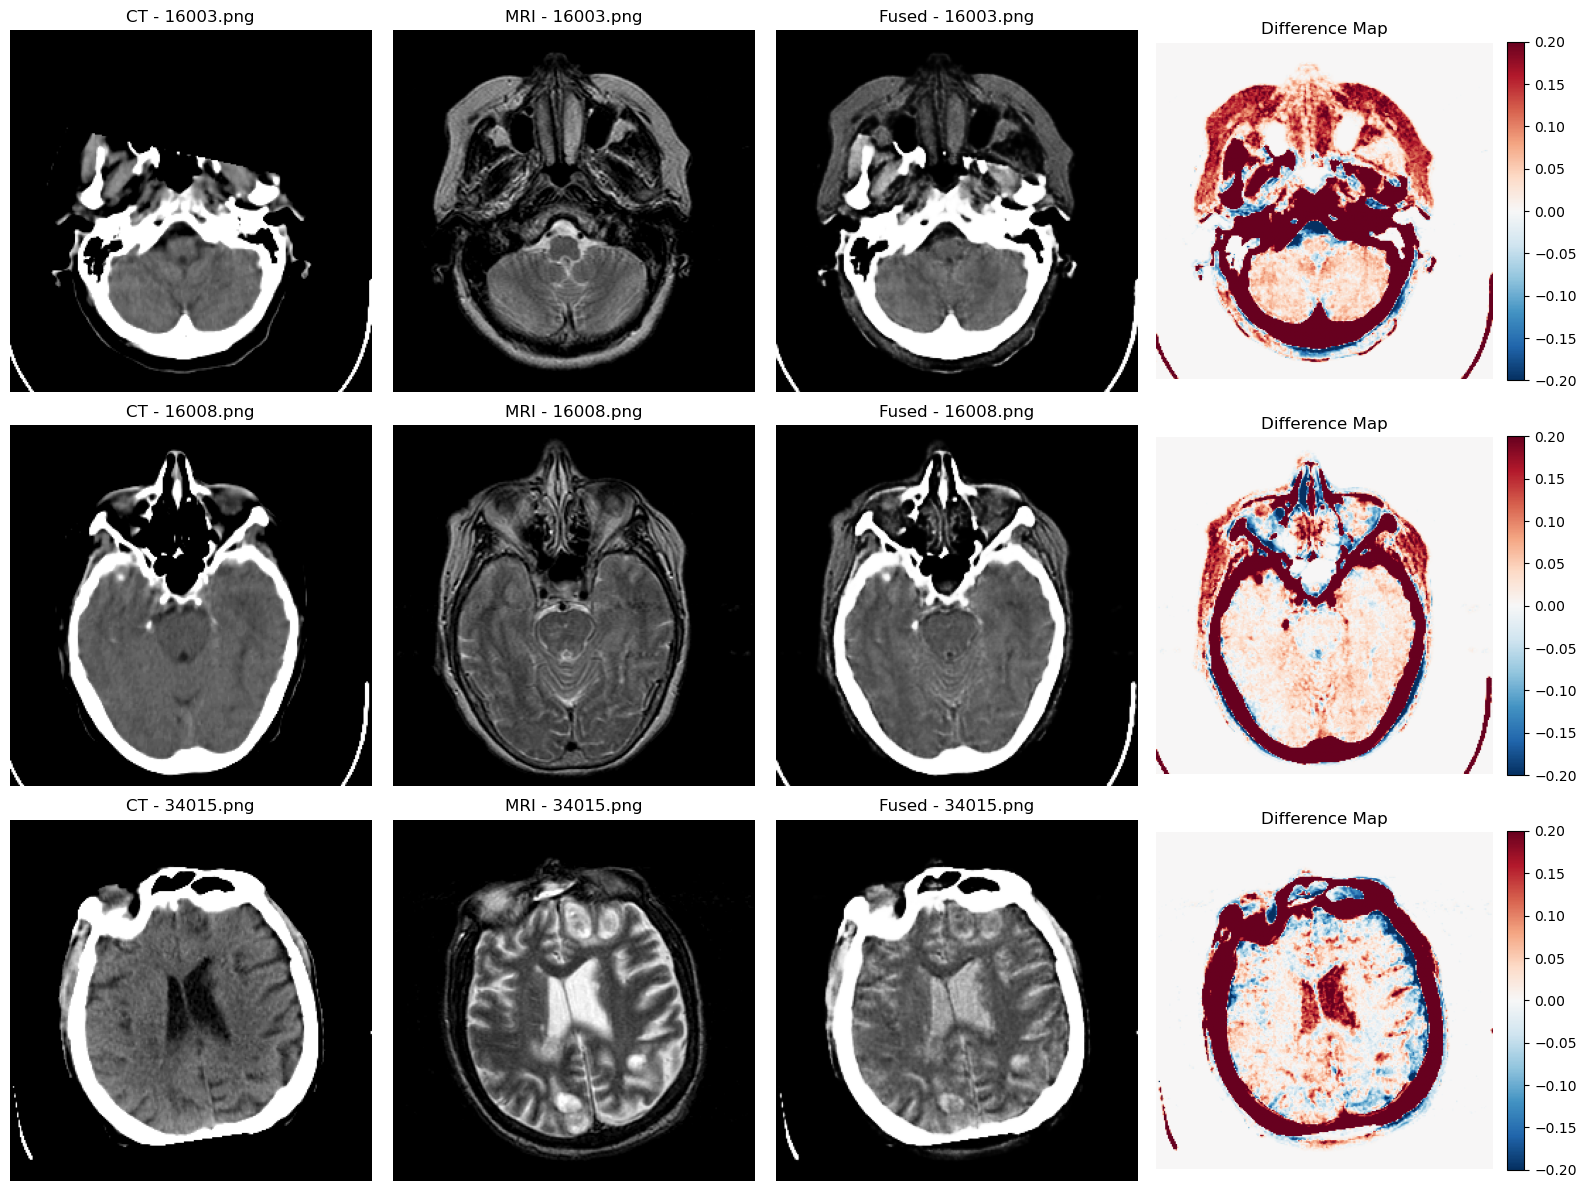

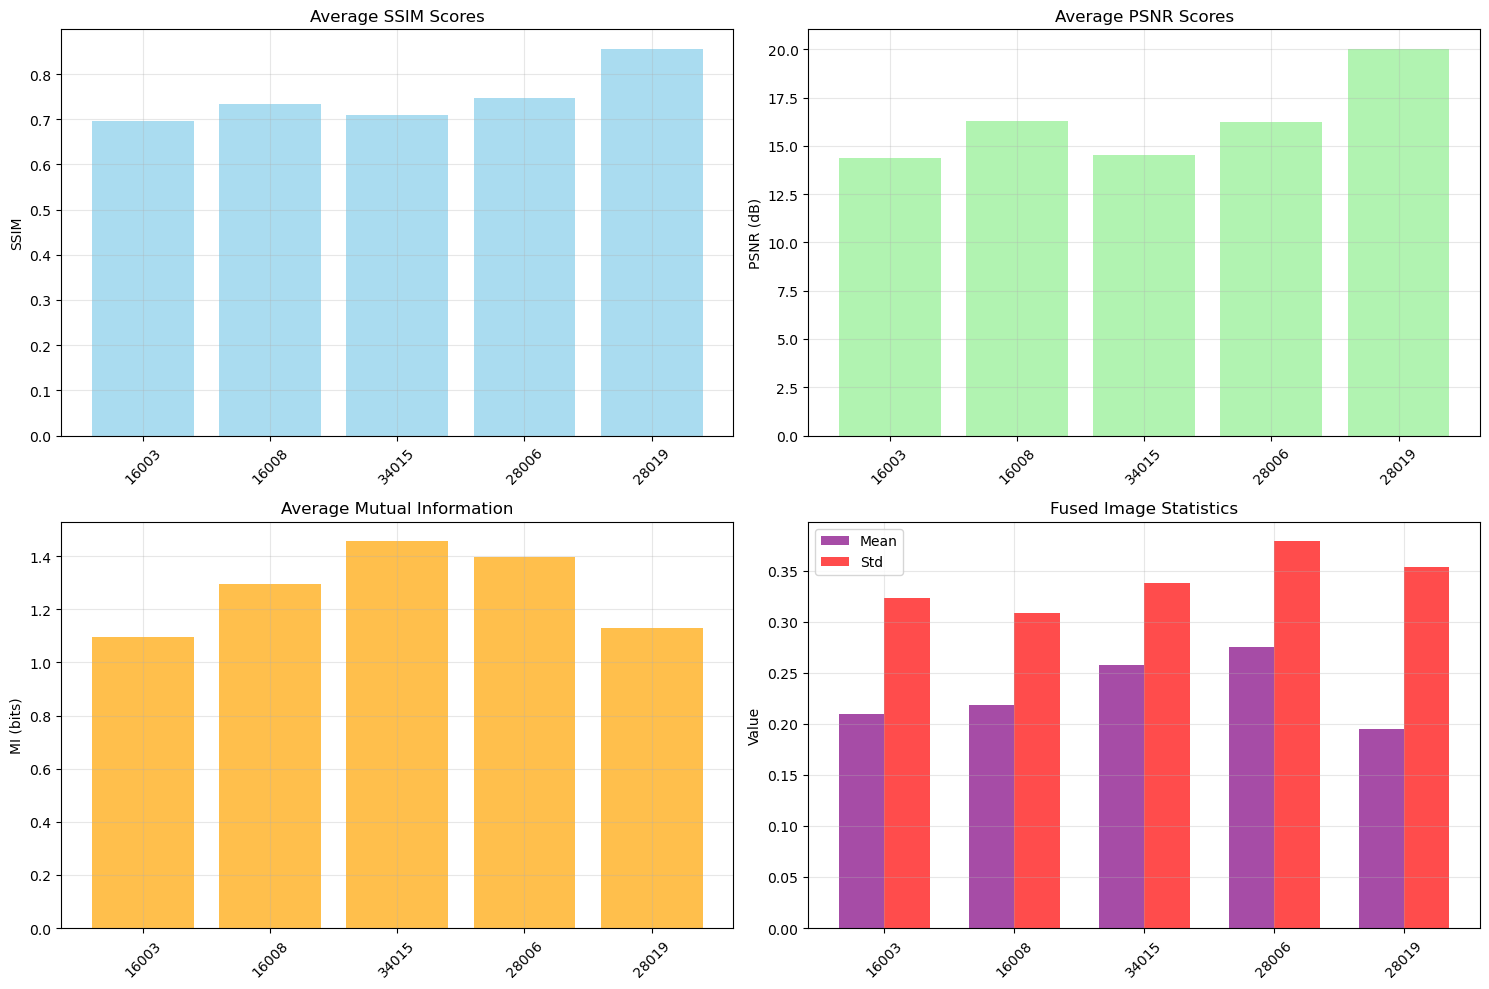

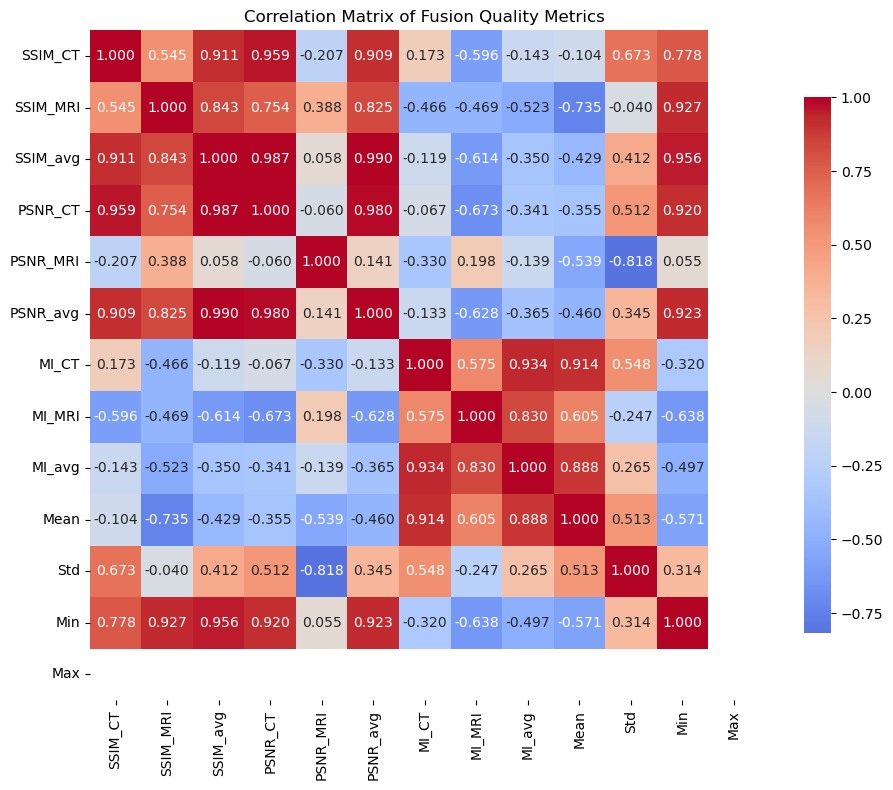


Visualization completed for 5 fusion results.


In [15]:
# Visualization of Fusion Results

def visualize_fusion_results(results, max_display=3):
    """Visualize fusion results with side-by-side comparisons."""
    if not results:
        print("No results to visualize")
        return
    
    num_display = min(max_display, len(results))
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_display, 4, figsize=(16, 4*num_display))
    if num_display == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_display):
        result = results[i]
        filename = result['filename']
        ct = result['ct']
        mri = result['mri']
        fused = result['fused']
        
        # Plot CT image
        axes[i, 0].imshow(ct, cmap='gray')
        axes[i, 0].set_title(f'CT - {filename}')
        axes[i, 0].axis('off')
        
        # Plot MRI image
        axes[i, 1].imshow(mri, cmap='gray')
        axes[i, 1].set_title(f'MRI - {filename}')
        axes[i, 1].axis('off')
        
        # Plot fused image
        axes[i, 2].imshow(fused, cmap='gray')
        axes[i, 2].set_title(f'Fused - {filename}')
        axes[i, 2].axis('off')
        
        # Plot difference map (fused - average of inputs)
        avg_input = (ct + mri) / 2
        diff = fused - avg_input
        im = axes[i, 3].imshow(diff, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
        axes[i, 3].set_title(f'Difference Map')
        axes[i, 3].axis('off')
        plt.colorbar(im, ax=axes[i, 3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def plot_fusion_metrics(evaluation_df):
    """Plot fusion quality metrics."""
    if evaluation_df.empty:
        print("No evaluation data to plot")
        return
    
    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # SSIM plot (if available)
    if 'SSIM_avg' in evaluation_df.columns:
        axes[0, 0].bar(range(len(evaluation_df)), evaluation_df['SSIM_avg'], 
                      color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Average SSIM Scores')
        axes[0, 0].set_ylabel('SSIM')
        axes[0, 0].set_xticks(range(len(evaluation_df)))
        axes[0, 0].set_xticklabels([f.split('.')[0] for f in evaluation_df['filename']], 
                                  rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'SSIM not available', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('SSIM Scores (Not Available)')
    
    # PSNR plot
    axes[0, 1].bar(range(len(evaluation_df)), evaluation_df['PSNR_avg'], 
                  color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Average PSNR Scores')
    axes[0, 1].set_ylabel('PSNR (dB)')
    axes[0, 1].set_xticks(range(len(evaluation_df)))
    axes[0, 1].set_xticklabels([f.split('.')[0] for f in evaluation_df['filename']], 
                              rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Mutual Information plot
    axes[1, 0].bar(range(len(evaluation_df)), evaluation_df['MI_avg'], 
                  color='orange', alpha=0.7)
    axes[1, 0].set_title('Average Mutual Information')
    axes[1, 0].set_ylabel('MI (bits)')
    axes[1, 0].set_xticks(range(len(evaluation_df)))
    axes[1, 0].set_xticklabels([f.split('.')[0] for f in evaluation_df['filename']], 
                              rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Statistics plot (Mean and Std)
    x = range(len(evaluation_df))
    width = 0.35
    axes[1, 1].bar([i - width/2 for i in x], evaluation_df['Mean'], width, 
                  label='Mean', color='purple', alpha=0.7)
    axes[1, 1].bar([i + width/2 for i in x], evaluation_df['Std'], width, 
                  label='Std', color='red', alpha=0.7)
    axes[1, 1].set_title('Fused Image Statistics')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].set_xticks(range(len(evaluation_df)))
    axes[1, 1].set_xticklabels([f.split('.')[0] for f in evaluation_df['filename']], 
                              rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_metric_correlation_plot(evaluation_df):
    """Create correlation plot between different metrics."""
    if evaluation_df.empty:
        print("No evaluation data for correlation plot")
        return
    
    # Select numeric columns for correlation
    numeric_cols = evaluation_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) < 2:
        print("Insufficient numeric data for correlation plot")
        return
    
    # Create correlation matrix
    correlation_matrix = evaluation_df[numeric_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix of Fusion Quality Metrics')
    plt.tight_layout()
    plt.show()

# Visualize results
print("="*60)
print("VISUALIZATION OF FUSION RESULTS")
print("="*60)

if fusion_results:
    # Show fusion results
    visualize_fusion_results(fusion_results, max_display=3)
    
    # Plot metrics
    if not evaluation_df.empty:
        plot_fusion_metrics(evaluation_df)
        create_metric_correlation_plot(evaluation_df)
    
    print(f"\nVisualization completed for {len(fusion_results)} fusion results.")
else:
    print("No fusion results available for visualization.")
    print("Please ensure the model is loaded and inference has been run successfully.")

## Summary and Analysis

### Model Performance Summary

This notebook provides comprehensive testing and evaluation of the ResNet-based fusion model. The evaluation includes:

1. **Quantitative Metrics:**
   - **SSIM (Structural Similarity Index)**: Measures structural similarity between fused and input images
   - **PSNR (Peak Signal-to-Noise Ratio)**: Measures reconstruction quality
   - **Mutual Information**: Measures information preservation from input modalities

2. **Visual Analysis:**
   - Side-by-side comparison of CT, MRI, and fused images
   - Difference maps showing fusion contributions
   - Statistical visualizations of quality metrics

3. **Model Architecture:**
   - ResNet50-based feature extraction with pretrained weights
   - Multi-level feature fusion (256, 512, 1024 channels)
   - Progressive upsampling with skip connections
   - End-to-end trainable fusion network

### Expected Performance Characteristics

Good fusion results should demonstrate:
- **High SSIM values** (>0.7) indicating preserved structural information
- **Balanced PSNR** with both input modalities
- **High Mutual Information** indicating effective information preservation
- **Visually coherent** fused images combining complementary information from CT and MRI

### Usage Instructions

1. **Prerequisites**: Ensure you have a trained ResNet fusion model checkpoint at `checkpoints_resnet/resnet_fusion_best.pt`
2. **Data**: Place test CT and MRI images in the specified directories with matching filenames
3. **Execution**: Run all cells sequentially to load model, process images, and generate evaluation results
4. **Customization**: Modify `num_test_samples` and resize parameters as needed for your specific use case

### Next Steps

- Compare results with other fusion methods (wavelet-based, etc.)
- Test on larger datasets for statistical significance
- Analyze failure cases and model limitations
- Consider ensemble approaches combining multiple fusion strategies